In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2

import pywt

import keras
from keras import backend as K
from keras.models import model_from_json
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras import regularizers, optimizers, losses, initializers

import tensorflow as tf
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [2]:
%run srcnn.py

In [3]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)
keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16760340281411244947
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3403743232
locality {
  bus_id: 1
}
incarnation: 11385825763598399292
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


### Load images

In [4]:
PATH = ""
TRAIN_FILE = PATH + "datasets/DIV2K_train_HR/"
TEST_FILE = PATH +"datasets/DIV2K_train_LR_wild/"
VALID_HR = PATH +"datasets/DIV2K_valid_HR/"
VALID_LR = PATH +"datasets/DIV2K_valid_LR_wild/"
obj_files = listdir(TRAIN_FILE )
valid_files = listdir(VALID_HR )

In [5]:
valid_files[:5]

['0844.png', '0881.png', '0873.png', '0878.png', '0813.png']

In [6]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]

In [7]:
#Load images

obj_img = []
train_img = []
valid_hr_img = []
valid_lr_img= []

for i in range(0,50): #should be replaced here with something random at some point
    n = obj_files[i]
    m = valid_files[i]
    obj_img.append(Image.open(TRAIN_FILE + n))
    train_img.append(Image.open(TEST_FILE + n[:-4]+"x4w1.png"))
    
    valid_hr_img.append(Image.open(VALID_HR +  m))
    valid_lr_img.append(Image.open(VALID_LR + m[:-4]+"x4w.png"))
#Only consider the luminance channel (YCrCb)
ycbcr_obj = convertToYCbCr(obj_img)
ycbcr_train = convertToYCbCr(train_img)
ycbr_valid_hr = convertToYCbCr(valid_hr_img)
ycbr_valid_lr = convertToYCbCr(valid_lr_img)

In [8]:
ycbcr_obj[0].size

(2040, 1356)

In [12]:
#Display images
def print_luminance(img, ch=3) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')

In [13]:
#Convert images to numpy array
imgs_label = [np.asarray(image) for image in ycbcr_obj]
imgs_train = [np.asarray(image) for image in ycbcr_train]
imgs_valid_hr = [np.asarray(image) for image in ycbr_valid_hr]
imgs_valid_lr = [np.asarray(image) for image in ycbr_valid_lr]


In [14]:
imgs_label[0].shape

(1356, 2040, 3)

(1356, 2040, 3)


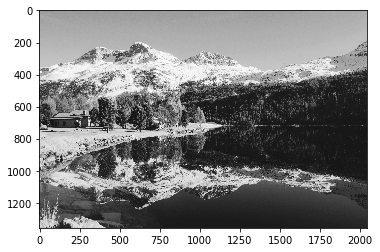

In [15]:
print(imgs_label[1].shape)
print_luminance(imgs_label[1])

(339, 510, 3)


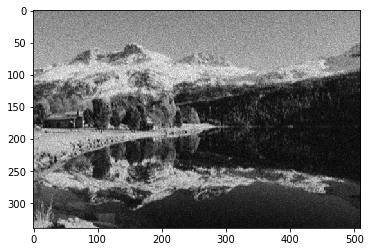

In [16]:
print(imgs_train[1].shape)
print_luminance(imgs_train[1])

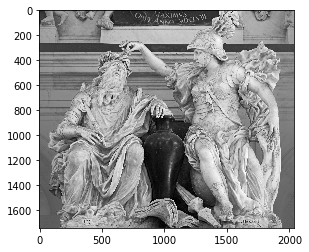

In [17]:
print_luminance(imgs_valid_hr[3])

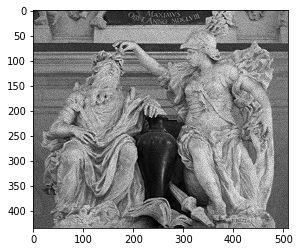

In [18]:
print_luminance(imgs_valid_lr[3])

### Generate train and test set

In [50]:
#Division by 4
window_size= 40 
scale = 4

In [51]:
def retSize(x):
    return (x.shape[0], x.shape[1])

In [52]:
def getSubImage(img, height, width, scale = 1) :
    window = window_size // scale
    return img[ height // 2 - window : height//2 + window,
                width // 2 - window: width//2 + window : ]

In [53]:
sub_labels = []
sub_samples = []
sub_valid_hr = []
sub_valid_lr = []

scale = 4
for i in range(0,50) :
    label = imgs_label[i]
    shape = imgs_train[i].shape
    s = cv2.resize(imgs_train[i], dsize = (shape[1]*4, shape[0]*4), interpolation = cv2.INTER_CUBIC)
    
    valid_hr = imgs_valid_hr[i]
    shape_lr = imgs_valid_lr[i].shape
    valid_lr = cv2.resize(imgs_valid_lr[i], dsize = (shape_lr[1]*4, shape_lr[0]*4), interpolation = cv2.INTER_CUBIC)
    
    height_label, width_label = retSize(label)
    height_sample, width_sample = retSize(s)
    height_hr, width_hr = retSize(valid_hr)
    height_vlr, width_vlr = retSize(valid_lr)
        
    #Calculate subimages
    sub_labels.append(getSubImage(label, height_label, width_label))
    sub_samples.append(getSubImage(s, height_sample, width_sample))
                      
    sub_valid_hr.append(getSubImage(valid_hr, height_hr,width_hr))
                        
    sub_valid_lr.append(getSubImage(valid_lr, height_vlr, width_vlr))

(80, 80, 3)

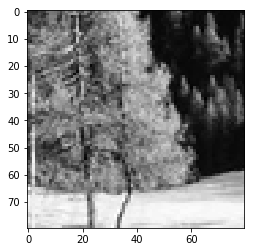

In [54]:
print_luminance(sub_labels[1])
sub_labels[1].shape

(80, 80, 3)

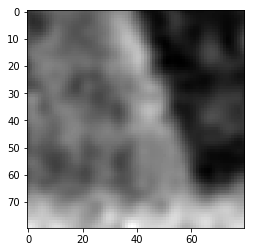

In [55]:
print_luminance(sub_samples[1])
sub_samples[1].shape

(80, 80, 3)

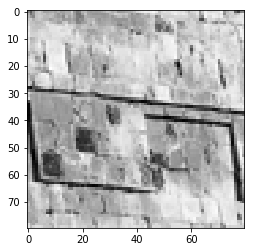

In [56]:
print_luminance(sub_valid_hr[1])
sub_valid_hr[1].shape

(80, 80, 3)

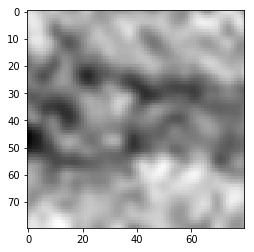

In [57]:
print_luminance(sub_valid_lr[1])
sub_valid_lr[1].shape

#### Generate the wavelets subbands

In [58]:
def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

In [59]:
y_sample = sub_labels[-1]
x_sample = sub_samples[-1]
print(y_sample.shape)
print(x_sample.shape)

(80, 80, 3)
(80, 80, 3)


In [60]:
def plot_waveletTrans(wt, ch=1) :
    fig = plt.figure(figsize=(10, 10))
    
    plt.subplot(221)
    plt.title("Average")
    print_luminance(wt[0], ch )
    plt.subplot(222)
    print_luminance(wt[1][0], ch)
    plt.subplot(223)
    print_luminance(wt[1][1], ch)
    plt.subplot(224)
    print_luminance(wt[1][2], ch)

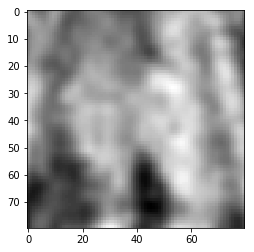

In [61]:
print_luminance(x_sample)

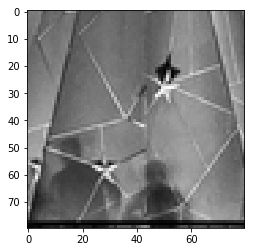

In [62]:
print_luminance(y_sample)

(45, 45)


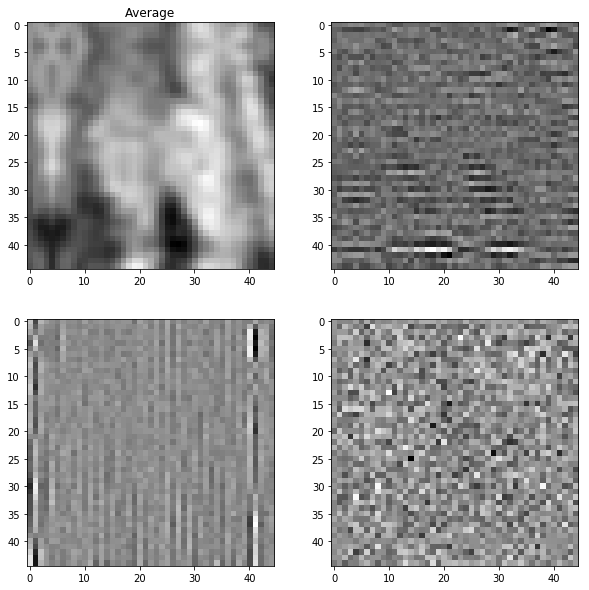

In [63]:
x_dwt = pywt.dwt2(x_sample[:,:, 0], 'db6')
print(x_dwt[0].shape)
plot_waveletTrans(x_dwt)

(45, 45)


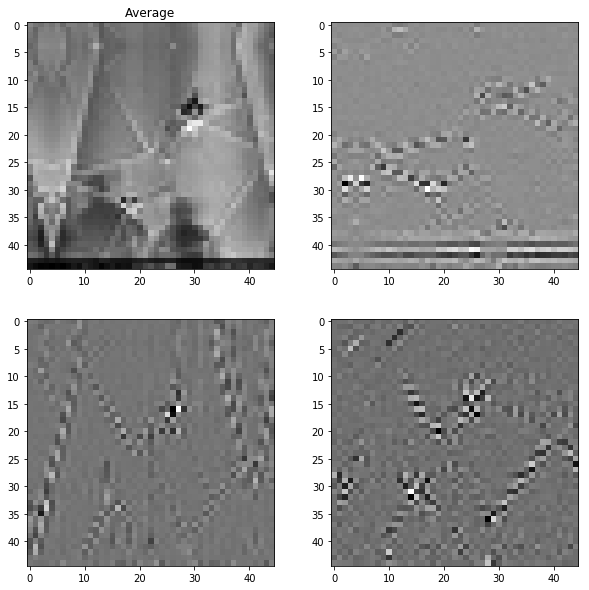

In [64]:
y_dwt = pywt.dwt2(y_sample[:,:, 0], 'db6')
print(y_dwt[0].shape)
plot_waveletTrans(y_dwt)

In [65]:
y_ll = []
y_lh = []
y_hl = []
y_hh = []

x_ll = []
x_lh = []
x_hl = []
x_hh = []

dwt_shape = []
dwt_hr_shape = []

valid_y_ll = []
valid_y_lh = []
valid_y_hl = []
valid_y_hh = []

valid_x_ll = []
valid_x_lh = []
valid_x_hl = []
valid_x_hh = []


for i in range(0,50) :
    y = sub_labels[i]
    x = sub_samples[i]
    vy = sub_valid_hr[i]
    vx = sub_valid_lr[i]
    
    dwt_y = pywt.dwt2(y[:, :, 0], 'db6')
    dwt_x = pywt.dwt2(x[:, :, 0], 'db6')
    dwt_hr = pywt.dwt2(vy[:, :, 0], 'db6')
    dwt_lr = pywt.dwt2(vx[:, :, 0], 'db6')
    
    y_ll, y_lh, y_hl, y_hh = appendSubbands(y_ll, y_lh, y_hl, y_hh, dwt_y)
    x_ll, x_lh, x_hl, x_hh = appendSubbands(x_ll, x_lh, x_hl, x_hh, dwt_x)

    valid_y_ll, valid_y_lh, valid_y_hl, valid_y_hh = appendSubbands(valid_y_ll, 
                                                                    valid_y_lh, 
                                                                    valid_y_hl, 
                                                                    valid_y_hh, dwt_hr)

    valid_x_ll, valid_x_lh, valid_x_hl, valid_x_hh = appendSubbands(valid_x_ll, 
                                                                    valid_x_lh, 
                                                                    valid_x_hl, 
                                                                    valid_x_hh, dwt_lr)
dwt_shape = dwt_x[0].shape
dwt_hr_shape = dwt_y[0].shape

#### Creating and Training the networks

In [66]:
def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

In [67]:
img_rows = dwt_shape[0]
img_cols = dwt_shape[1]

channel = K.image_data_format()

x_train = reshape(x_ll, dwt_shape, channel)
y_train = reshape(y_ll, dwt_hr_shape, channel)
x_test = reshape(valid_x_ll, dwt_shape, channel)
y_test = reshape(valid_y_ll, dwt_hr_shape, channel)
input_shape_ = (img_rows, img_cols, 1)

In [68]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3,3),strides=(1,1),padding='same',
                 activation='selu',
                 input_shape=input_shape_,
                 kernel_regularizer=regularizers.l2(0.0001)))

model.add(Conv2D(128, (3, 3),strides=(1,1), activation='selu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(1, (3, 3),strides=(1,1), activation='selu', padding='same'))

model.compile(optimizer=Adam(),
         loss='mse',
         metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 45, 45, 128)       1280      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 45, 45, 128)       512       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 1)         1153      
Total params: 150,529
Trainable params: 150,273
Non-trainable params: 256
_________________________________________________________________


In [69]:
history_CNN = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=150, batch_size=50, verbose=1)

Train on 50 samples, validate on 50 samples
Epoch 1/150
50/50 [==============================] - 1s 22ms/step - loss: 71866.2656 - acc: 0.0000e+00 - val_loss: 64649.2188 - val_acc: 0.0000e+00
Epoch 2/150
50/50 [==============================] - 0s 3ms/step - loss: 71068.6484 - acc: 0.0000e+00 - val_loss: 67033.6406 - val_acc: 0.0000e+00
Epoch 3/150
50/50 [==============================] - 0s 3ms/step - loss: 70648.6094 - acc: 0.0000e+00 - val_loss: 67715.4141 - val_acc: 0.0000e+00
Epoch 4/150
50/50 [==============================] - 0s 3ms/step - loss: 70379.2031 - acc: 0.0000e+00 - val_loss: 66861.9297 - val_acc: 0.0000e+00
Epoch 5/150
50/50 [==============================] - 0s 3ms/step - loss: 70044.7188 - acc: 0.0000e+00 - val_loss: 66226.6016 - val_acc: 0.0000e+00
Epoch 6/150
50/50 [==============================] - 0s 3ms/step - loss: 69718.4531 - acc: 0.0000e+00 - val_loss: 66283.8672 - val_acc: 0.0000e+00
Epoch 7/150
50/50 [==============================] - 0s 3ms/step - loss: 

Epoch 57/150
50/50 [==============================] - 0s 3ms/step - loss: 51277.5898 - acc: 0.0000e+00 - val_loss: 57764.6289 - val_acc: 0.0000e+00
Epoch 58/150
50/50 [==============================] - 0s 3ms/step - loss: 50903.4844 - acc: 0.0000e+00 - val_loss: 57077.6992 - val_acc: 0.0000e+00
Epoch 59/150
50/50 [==============================] - 0s 3ms/step - loss: 50507.2617 - acc: 0.0000e+00 - val_loss: 56443.1367 - val_acc: 0.0000e+00
Epoch 60/150
50/50 [==============================] - 0s 3ms/step - loss: 50113.1953 - acc: 0.0000e+00 - val_loss: 55977.1797 - val_acc: 0.0000e+00
Epoch 61/150
50/50 [==============================] - 0s 3ms/step - loss: 49719.8086 - acc: 0.0000e+00 - val_loss: 55579.4531 - val_acc: 0.0000e+00
Epoch 62/150
50/50 [==============================] - 0s 3ms/step - loss: 49320.3867 - acc: 0.0000e+00 - val_loss: 55849.6406 - val_acc: 0.0000e+00
Epoch 63/150
50/50 [==============================] - 0s 3ms/step - loss: 48950.1719 - acc: 0.0000e+00 - val_los

Epoch 113/150
50/50 [==============================] - 0s 3ms/step - loss: 31663.3770 - acc: 0.0000e+00 - val_loss: 32724.9141 - val_acc: 0.0000e+00
Epoch 114/150
50/50 [==============================] - 0s 3ms/step - loss: 31367.2656 - acc: 0.0000e+00 - val_loss: 31660.2383 - val_acc: 0.0000e+00
Epoch 115/150
50/50 [==============================] - 0s 3ms/step - loss: 31077.3066 - acc: 0.0000e+00 - val_loss: 32783.7930 - val_acc: 0.0000e+00
Epoch 116/150
50/50 [==============================] - 0s 3ms/step - loss: 30779.1797 - acc: 0.0000e+00 - val_loss: 32469.5703 - val_acc: 0.0000e+00
Epoch 117/150
50/50 [==============================] - 0s 3ms/step - loss: 30495.3496 - acc: 0.0000e+00 - val_loss: 31976.1621 - val_acc: 0.0000e+00
Epoch 118/150
50/50 [==============================] - 0s 3ms/step - loss: 30204.1953 - acc: 0.0000e+00 - val_loss: 31714.6152 - val_acc: 0.0000e+00
Epoch 119/150
50/50 [==============================] - 0s 3ms/step - loss: 29919.6953 - acc: 0.0000e+00 - 

#### Original image and bicubic interpolated image

In [ ]:
'''label = modcrop(imgs[0], scale)
h, w = retSize(label)
sample = bicubicInterpolation(label, 1/3, (h,w))

fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
print_luminance(label)
getSize(label)
plt.subplot(122)
print_luminance(sample)

plt.show()'''


In [ ]:
'''## Verify all images have the same size

samples_size = [s for s in samples if s.shape != (32, 32, 3)]
assert len(samples_size) == 0
labels_size = [s for s in labels if s.shape != (20, 20, 3)]
assert len(labels_size) == 0
count'''

#### Example of our train and test set images

In [ ]:
'''fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
print_luminance(samples[0])
getSize(label)
plt.subplot(122)
print_luminance(labels[0])
'''